## Q2: Conduct a customer segmentation for the wholesale distributor dataset.

* Student ID: p233340 
* Name: Kwok Tsz Yi
* Course: COM6101 

In [286]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# import dataset
import pandas as pd
df = pd.read_csv('Q2.csv')
df.head()

,CustID,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,1,online,Shenzhen,12669,9656,7561,214,2674.0,1338
1,2,online,Shenzhen,7057,9810,9568,1762,3293.0,1776
2,3,online,Shenzhen,6353,8808,7684,2405,3516.0,7844
3,4,offline,Shenzhen,13265,1196,4221,6404,507.0,1788
4,5,online,Shenzhen,22615,5410,7198,3915,1777.0,5185


## Data Preprocessing

Size of the dataset:

In [287]:
df.shape

(440, 9)

Data types of the dataset:

In [288]:
df.dtypes

CustID                int64
Channel              object
Region               object
Fresh                object
Milk                  int64
Grocery               int64
Frozen                int64
Detergents_Paper    float64
Delicatessen          int64
dtype: object

As the CustID is not useful for the clustering, this column will be dropped.

In [289]:
df = df.drop(['CustID'], axis=1)

For column Fresh, it should be a numerical value, but pandas read it as an object. Transform it to numerical value.

In [290]:
# there is a strange value in df['Fresh'], which equals to ab9
df['Fresh'][df['Fresh'] == 'ab9']

66    ab9
Name: Fresh, dtype: object

In [291]:
# remove the strange value
df = df[df['Fresh'] != 'ab9']
df["Fresh"] = df["Fresh"].astype('int')

Missing values in the dataset:

In [292]:
# find rows with missing values
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    1
Delicatessen        0
dtype: int64

Handle the only missing value in the dataset: fill in the Detergents_Paper NaN with median value.

In [293]:
median_detergents_paper = df['Detergents_Paper'].median()
df['Detergents_Paper'] = df['Detergents_Paper'].fillna(median_detergents_paper)
df.isnull().sum() # check if the missing values are filled

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicatessen        0
dtype: int64

### Data Preprocessing: Outlier Detection and Removal

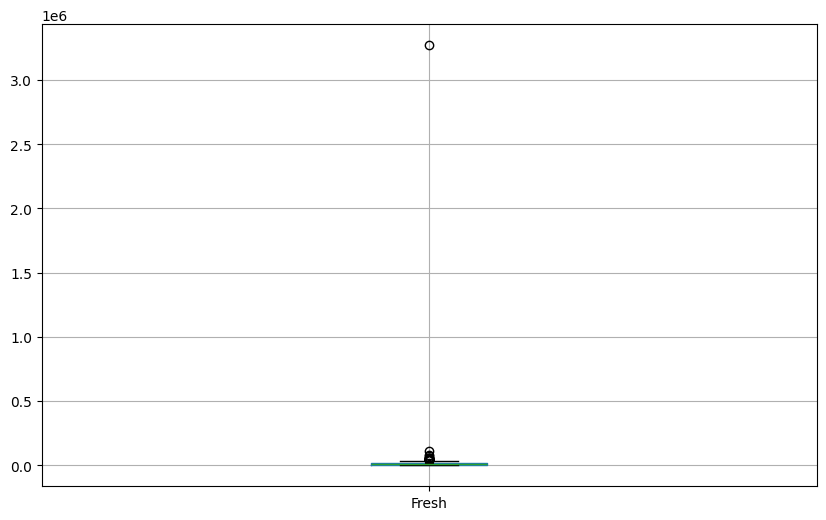

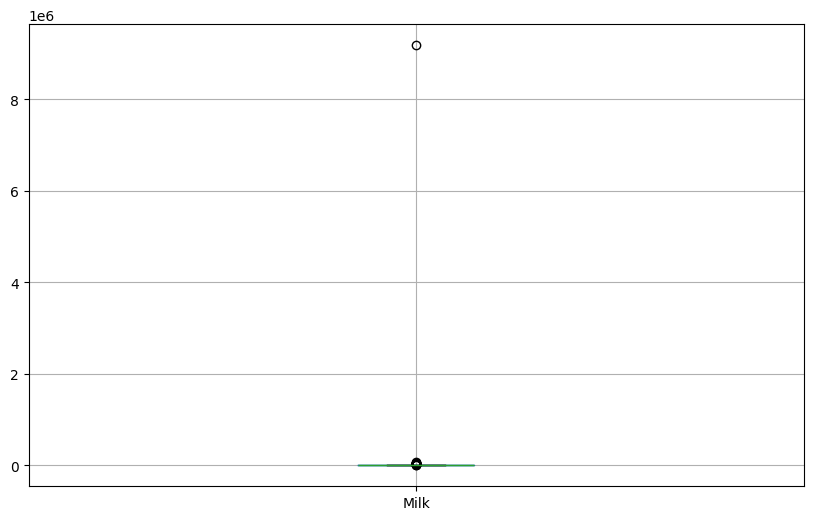

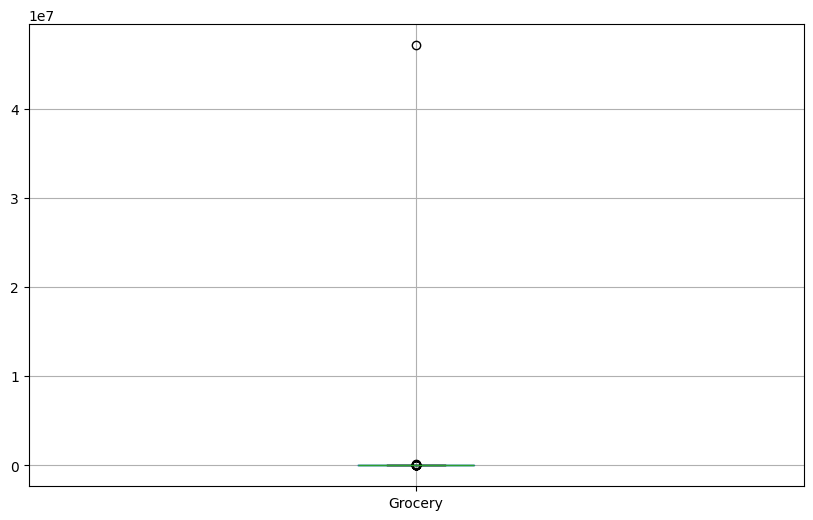

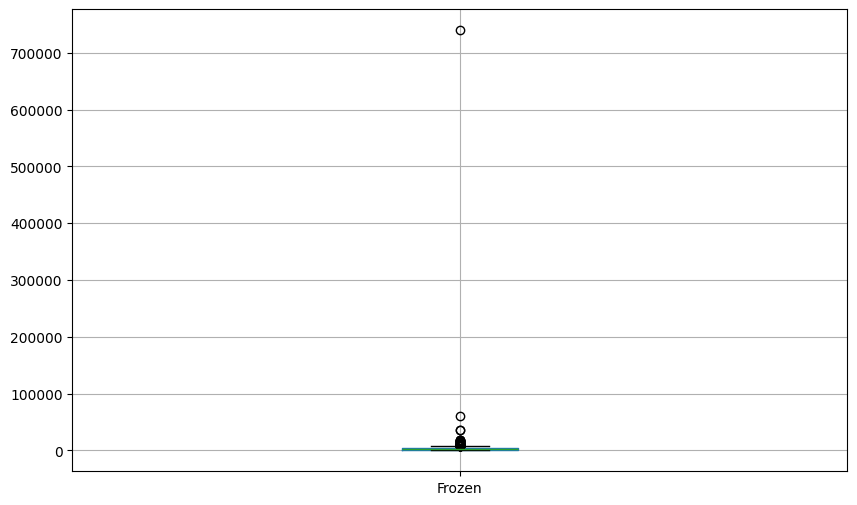

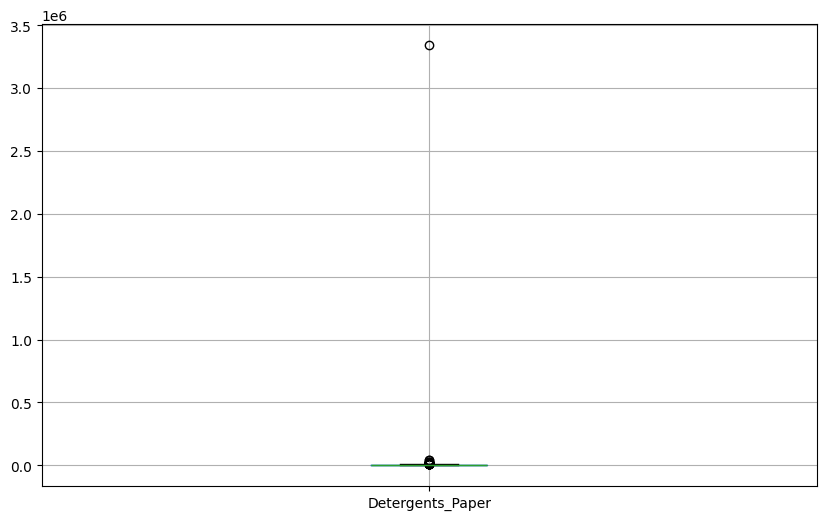

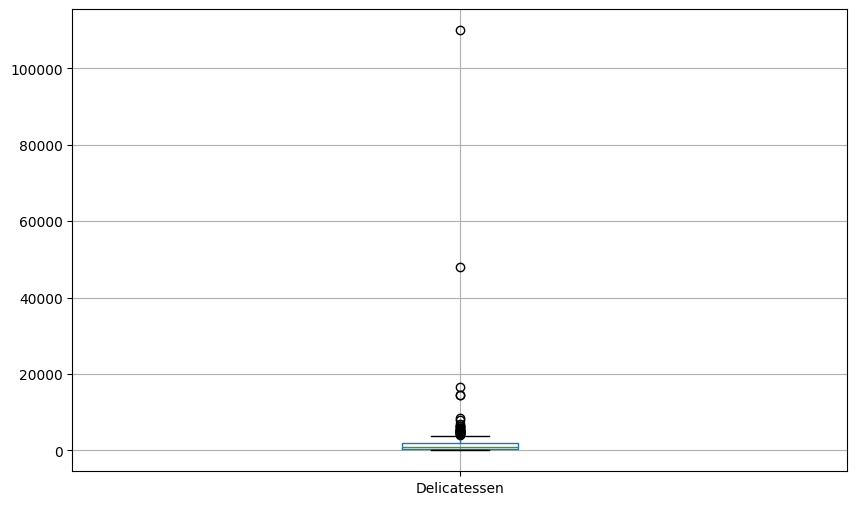

In [294]:
# use boxplot to visualize the distribution of each product
for i in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    df.boxplot(column=i)
    plt.show()

As per the boxplot, there are extreme values in the dataset, the customer clustering results will be affected by these outliers. Therefore, the outliers will be removed from the dataset.

In [295]:
# define extreme values as the 95th percentile of each product
# find outliers in numerical columns
df_1 = df.select_dtypes(include='number') # exclude non-numeric columns first
extreme_Q = df_1.quantile(0.95, numeric_only=True)
extreme_value = df_1[(df_1 > extreme_Q)]
extreme_value.count().sum()

132

There are 110 extreme values in the dataset, these extreme values will be replaced by 0.95 quantile value.

As per the above analysis, we can see that due to one particular extreme value in the Grocery Sales of SZ, the mean of the Grocery Sales is significantly higher than the median. Therefore, we can consider this as an outlier and remove it from the dataset.

In [296]:
# set the maximum value to the 95th percentile
df_1 = df_1.apply(lambda x: x.clip(upper=x.quantile(0.95)))
extreme_Q = df_1.quantile(0.95, numeric_only=True)
extreme_value = df_1[(df_1 > extreme_Q)]
# apply the clip function to the original dataframe
df[df_1.columns] = df_1
# check if in the original dataframe, the maximum value of each column is the 95th percentile
df[df_1.columns].max()

Fresh               36865.9
Milk                18041.2
Grocery             24714.5
Frozen              10017.3
Detergents_Paper    12237.0
Delicatessen         4646.3
dtype: float64

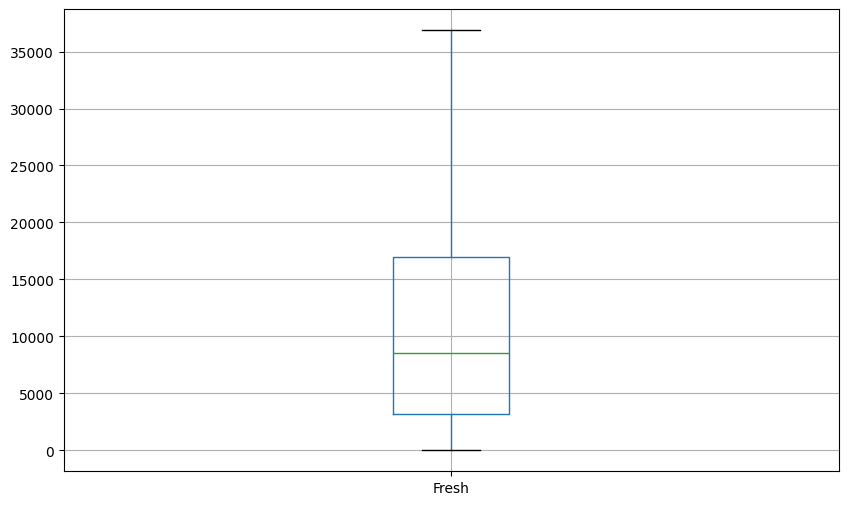

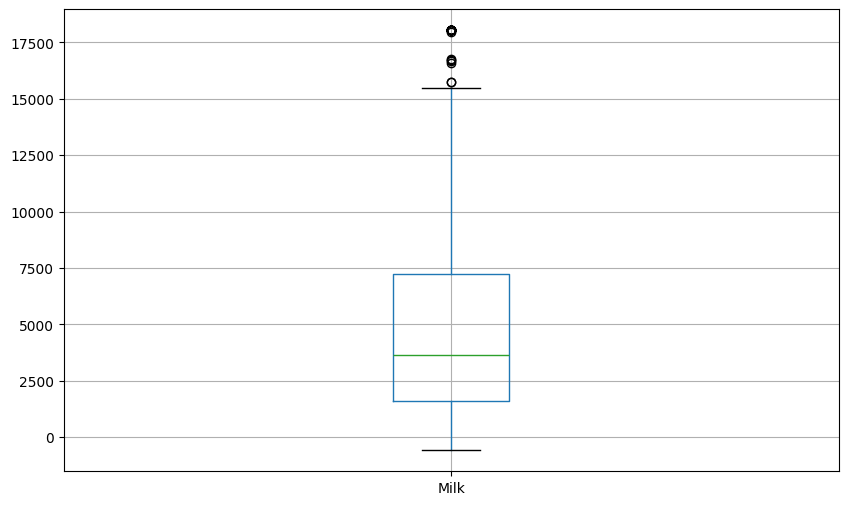

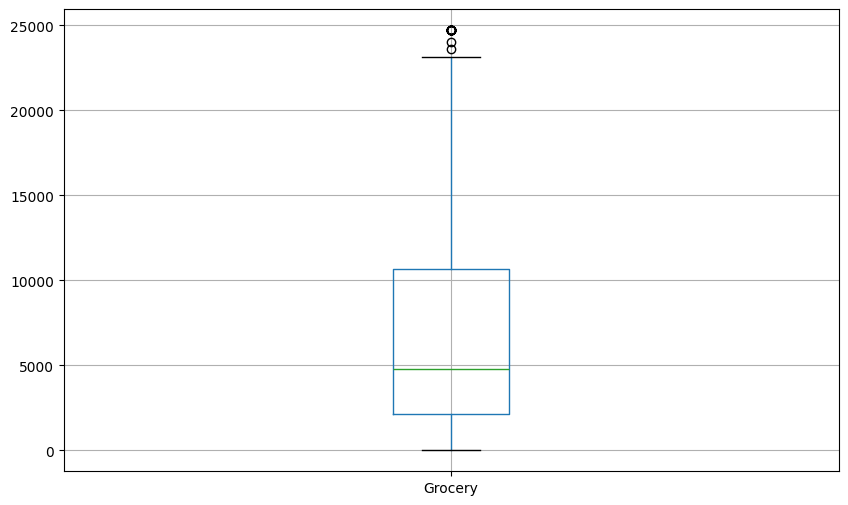

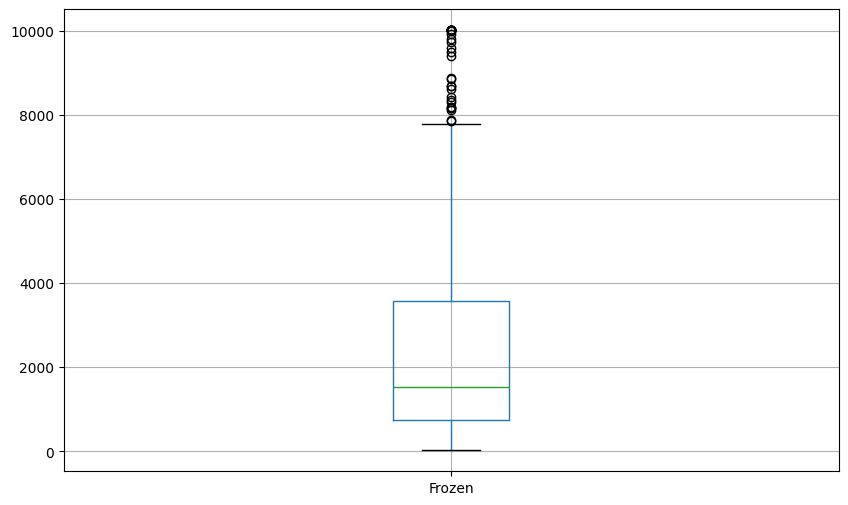

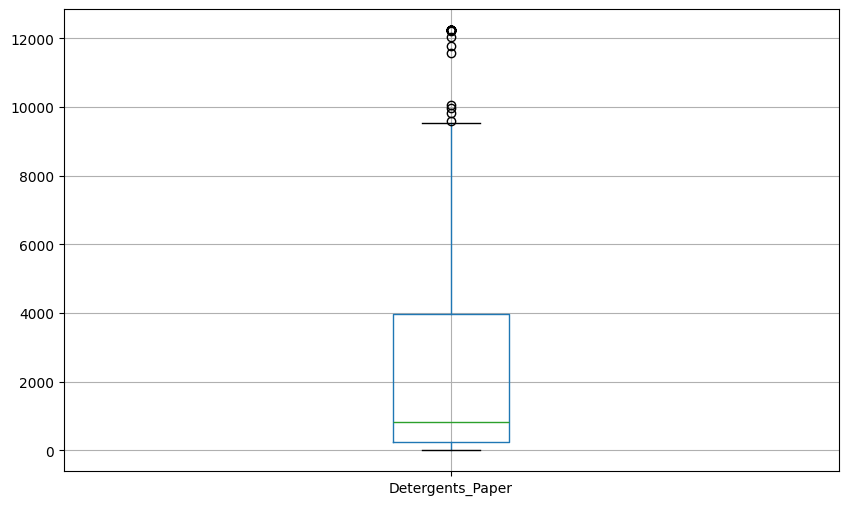

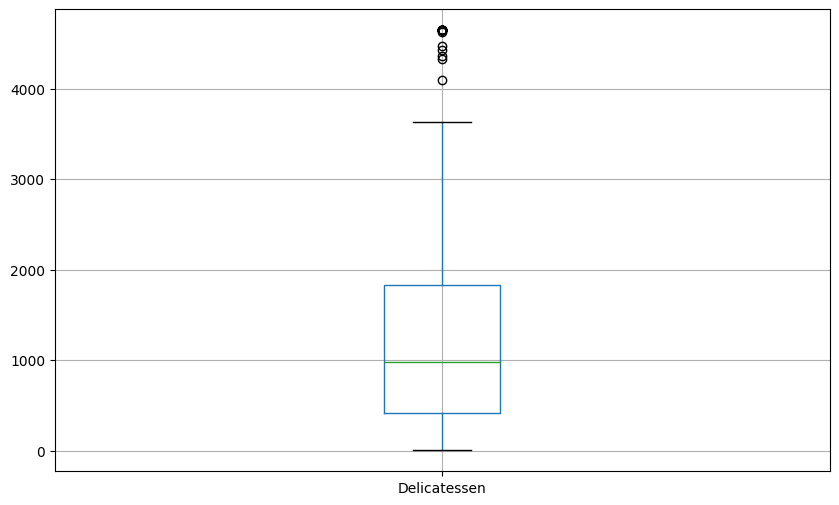

In [297]:
# observe the data distribution with boxplot
for i in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    df.boxplot(column=i)
    plt.show()

## Exploratory Data Analysis

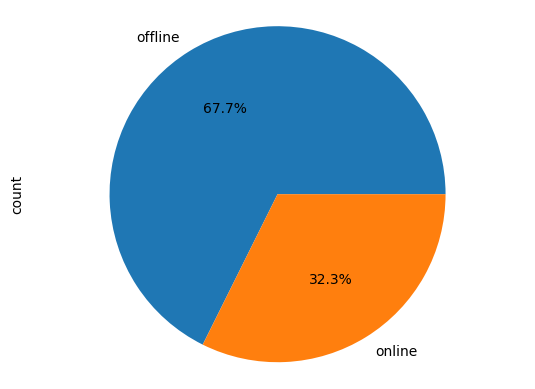

In [298]:
# pie chart for categorical data
import matplotlib.pyplot as plt
df['Channel'].value_counts().plot.pie(autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Most customers purchase from the offline channel, with only about 30% of the customers purchasing from the online channel.

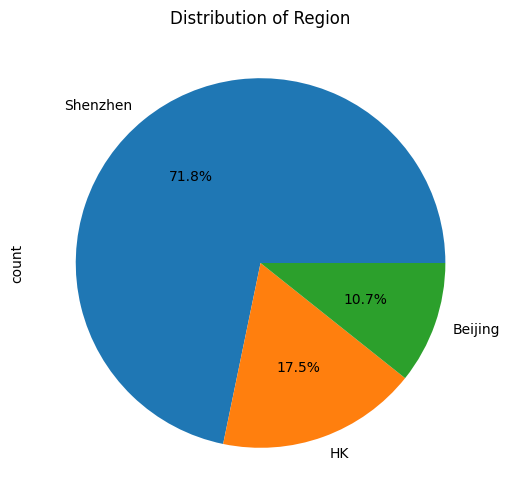

In [299]:
# pie chart for the distribution of the region
plt.figure(figsize=(10, 6))
df['Region'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Region')
plt.show()

For the regional distribution, the majority of the customers are from Shenzen, followed by Hong Kong and Beijing.

### Clustering Analysis

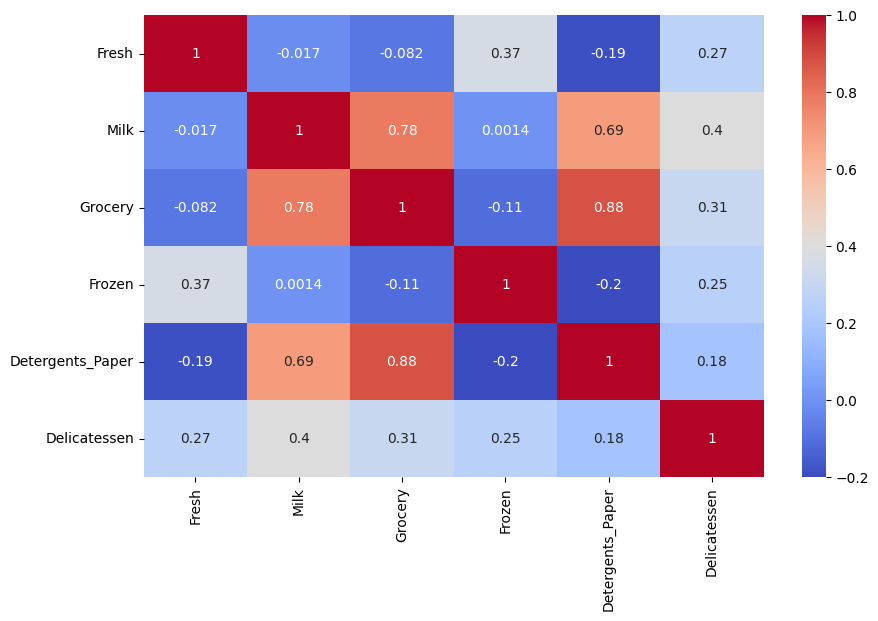

In [300]:
import seaborn as sns
# take a look at the correlation heatmap first, exclude the non-numeric columns and the CustID
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

Text(0, 0.5, 'WCSS')

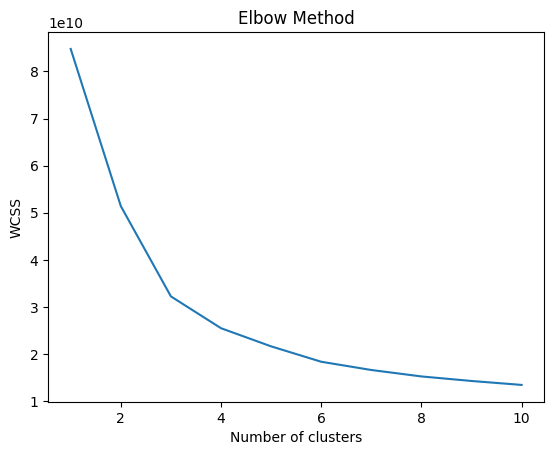

In [301]:
# use the elbow method to find the optimal number of clusters
X = df.select_dtypes(include='number')
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

As per the Elbow Method, the turning point is either at k = 2 or k = 3, hence we will choose k = 2 or k = 3 for the clustering analysis.

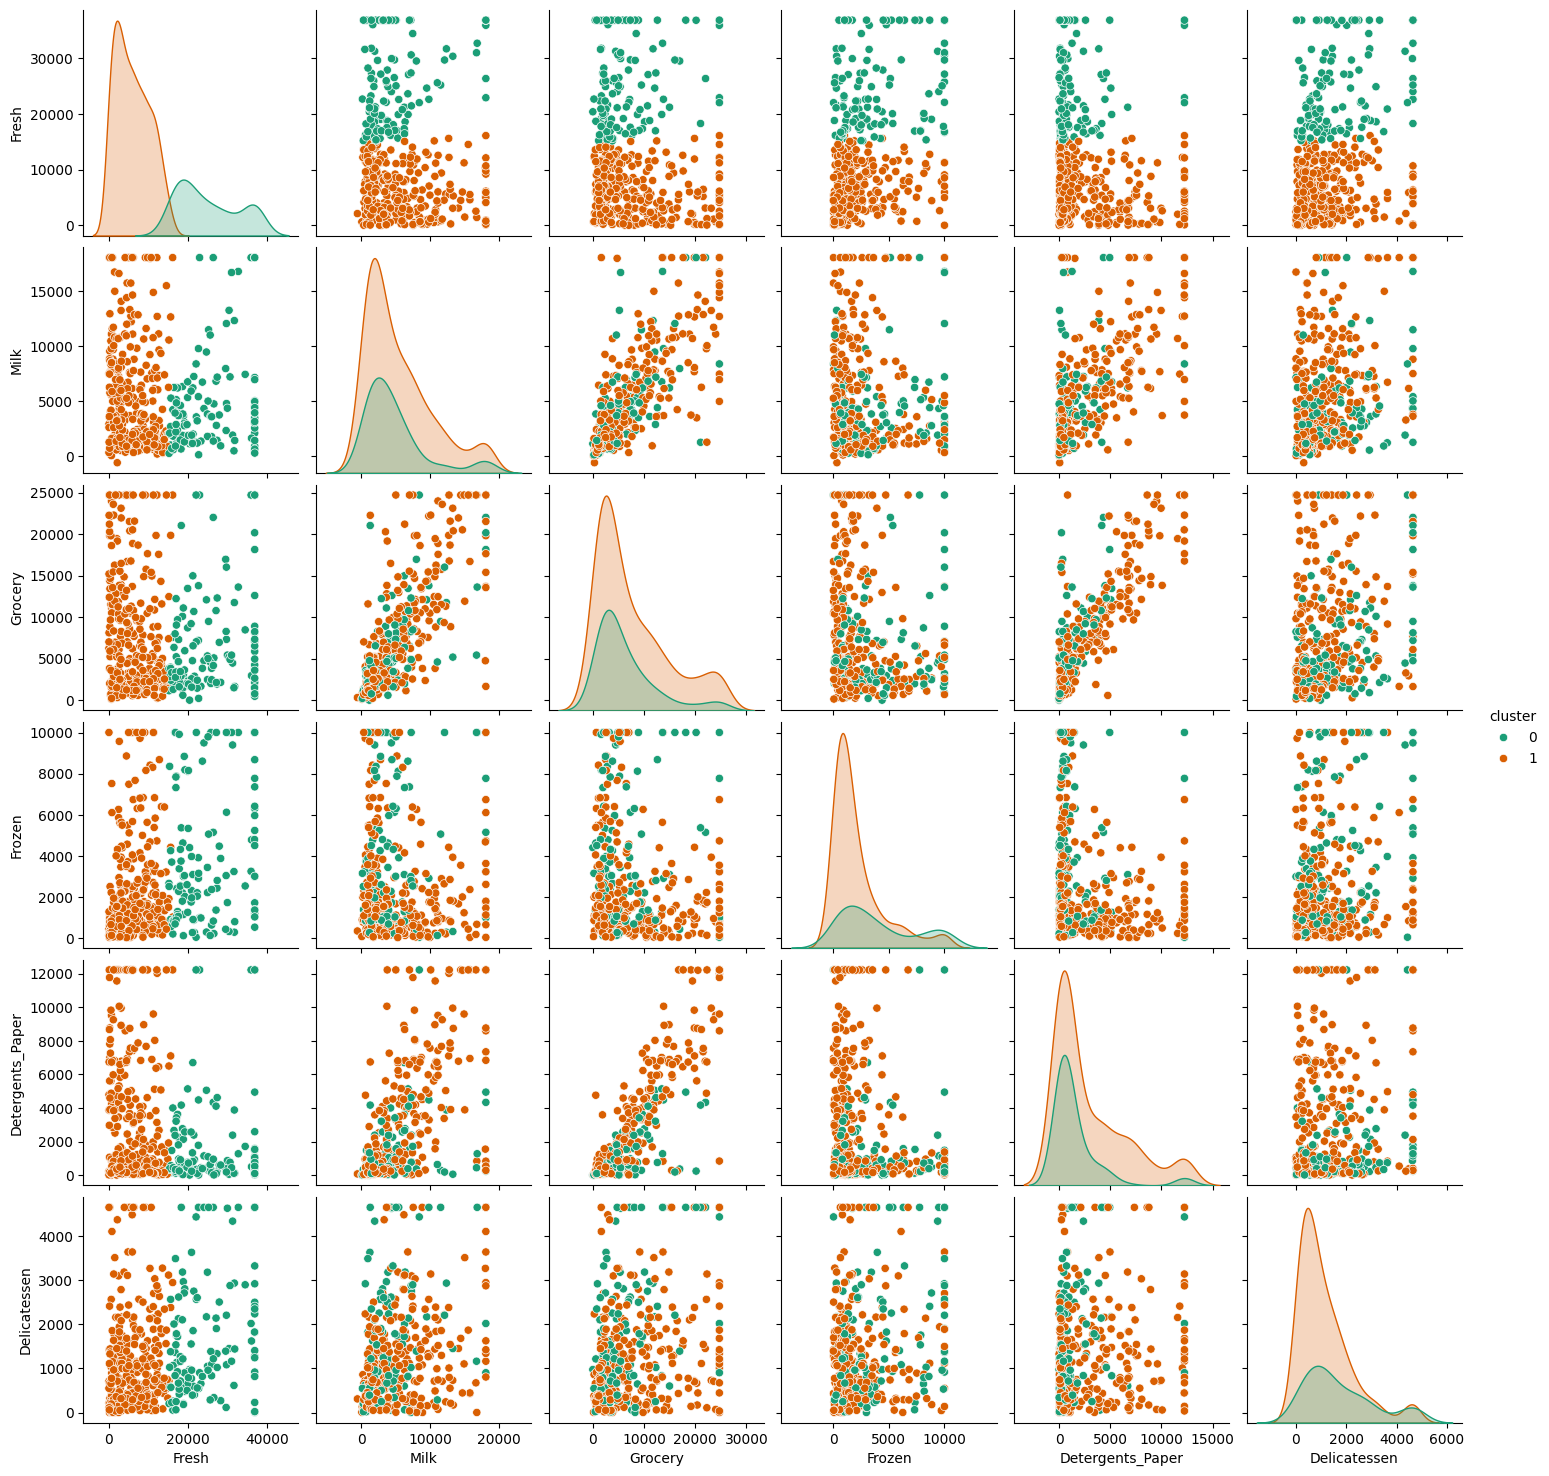

In [302]:
# use 2 clusters to fit the model
kmeans_2 = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans_2 = kmeans_2.fit_predict(X)

# plot a pairplot to visualize the clusters
df_2 = df.copy()
df_2['cluster'] = y_kmeans_2
sns.pairplot(df_2, hue='cluster', palette='Dark2')

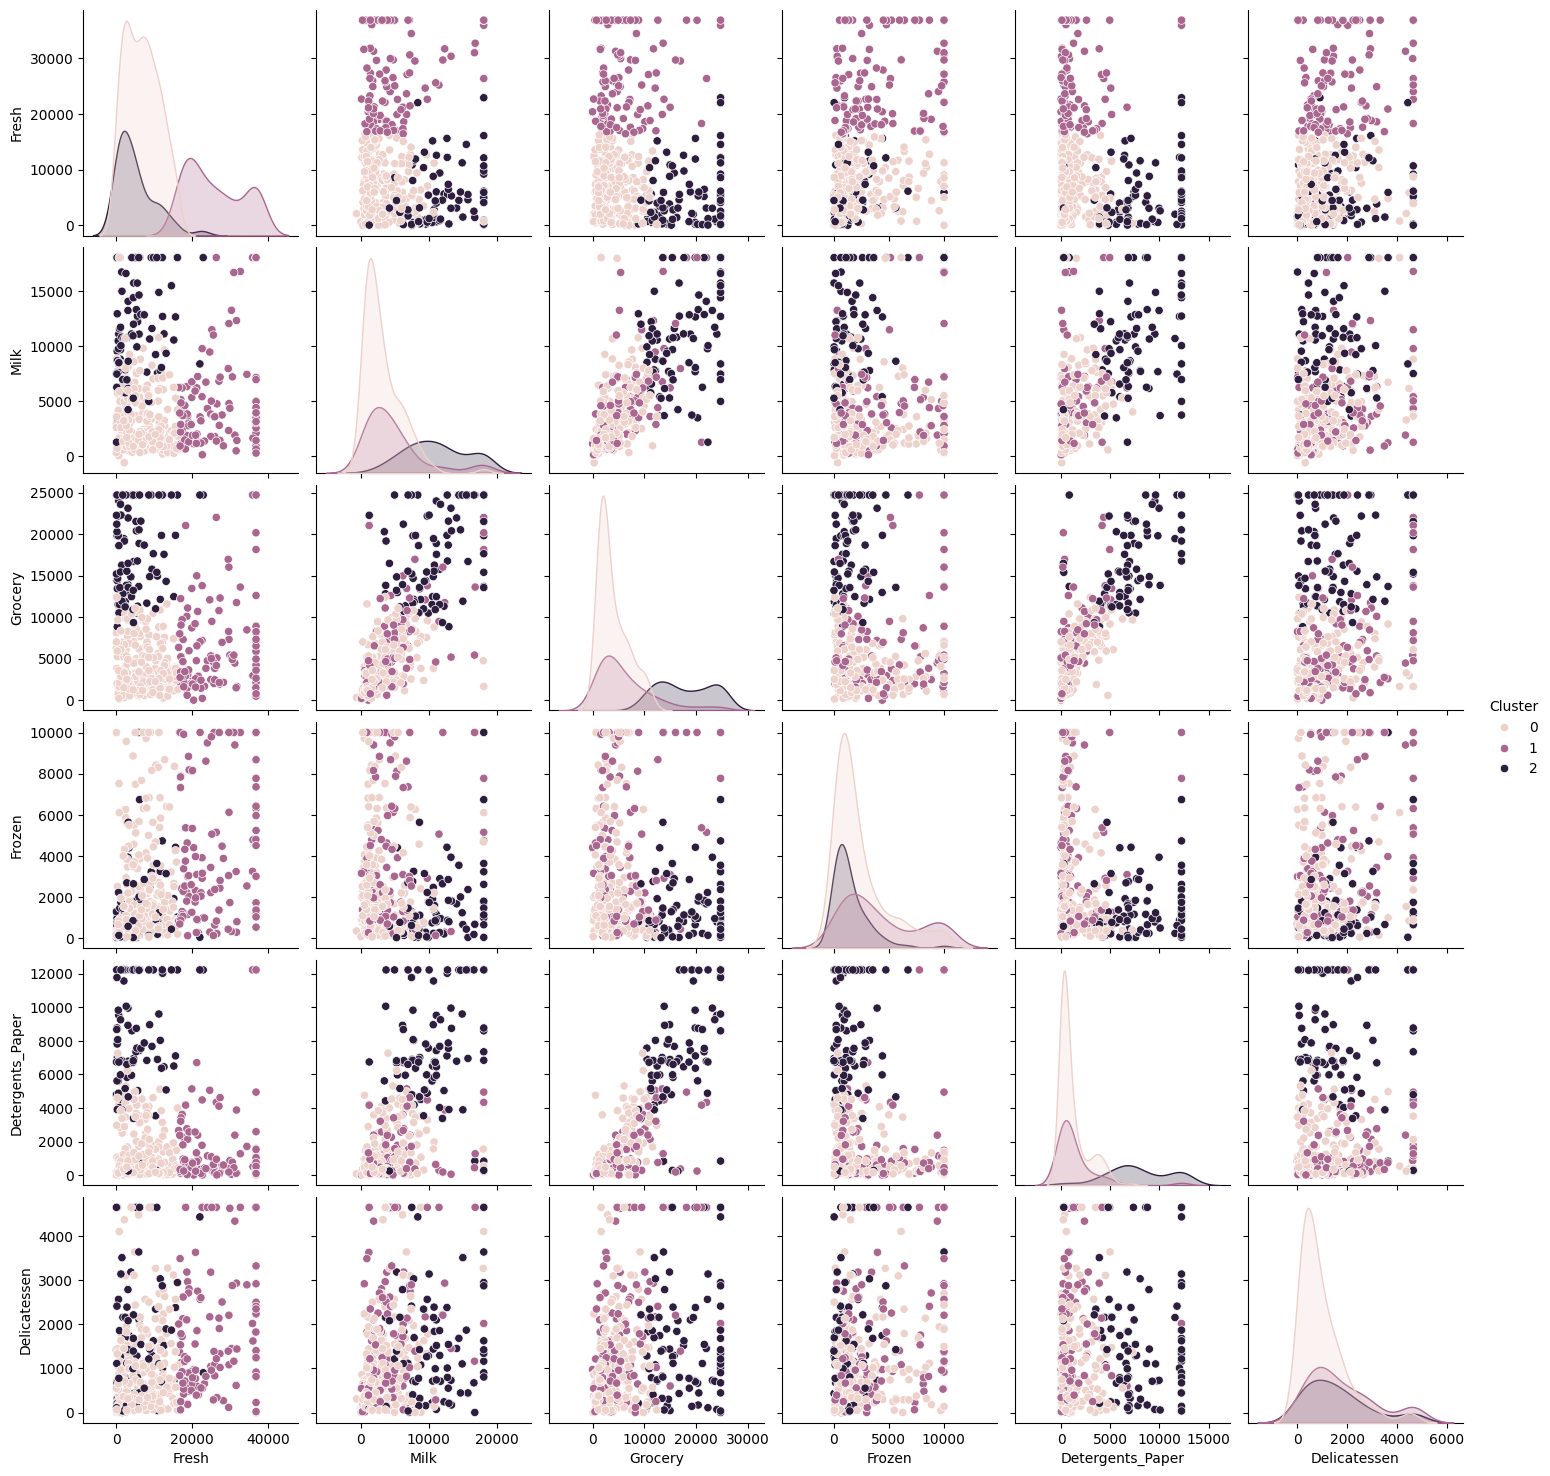

In [303]:
# use 3 clusters to fit the data
kmeans_3 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans_3 = kmeans_3.fit_predict(X)

# plot a pairplot to visualize the clusters
df_3 = df.copy()
df_3['Cluster'] = y_kmeans_3
sns.pairplot(df_3, hue='Cluster')

For n_clusters = 2, the average silhouette_score is : 0.39829546318956227
For n_clusters = 3, the average silhouette_score is : 0.41101747014819345
For n_clusters = 4, the average silhouette_score is : 0.34073377447335107
For n_clusters = 5, the average silhouette_score is : 0.33078499744288076
For n_clusters = 6, the average silhouette_score is : 0.33805410579000816


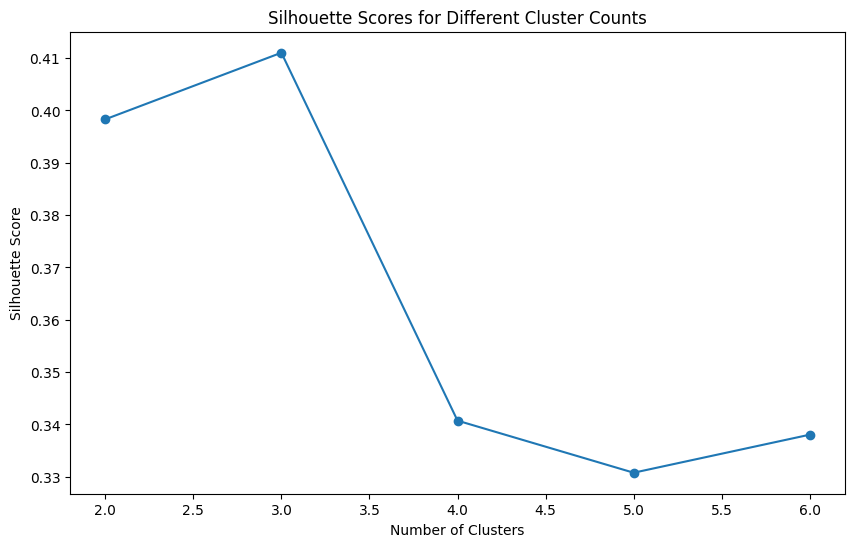

In [304]:
#Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title("Silhouette Scores for Different Cluster Counts")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.39829546318956227
For n_clusters = 3, the average silhouette_score is : 0.41101747014819345
For n_clusters = 4, the average silhouette_score is : 0.34073377447335107
For n_clusters = 5, the average silhouette_score is : 0.33078499744288076
For n_clusters = 6, the average silhouette_score is : 0.33805410579000816


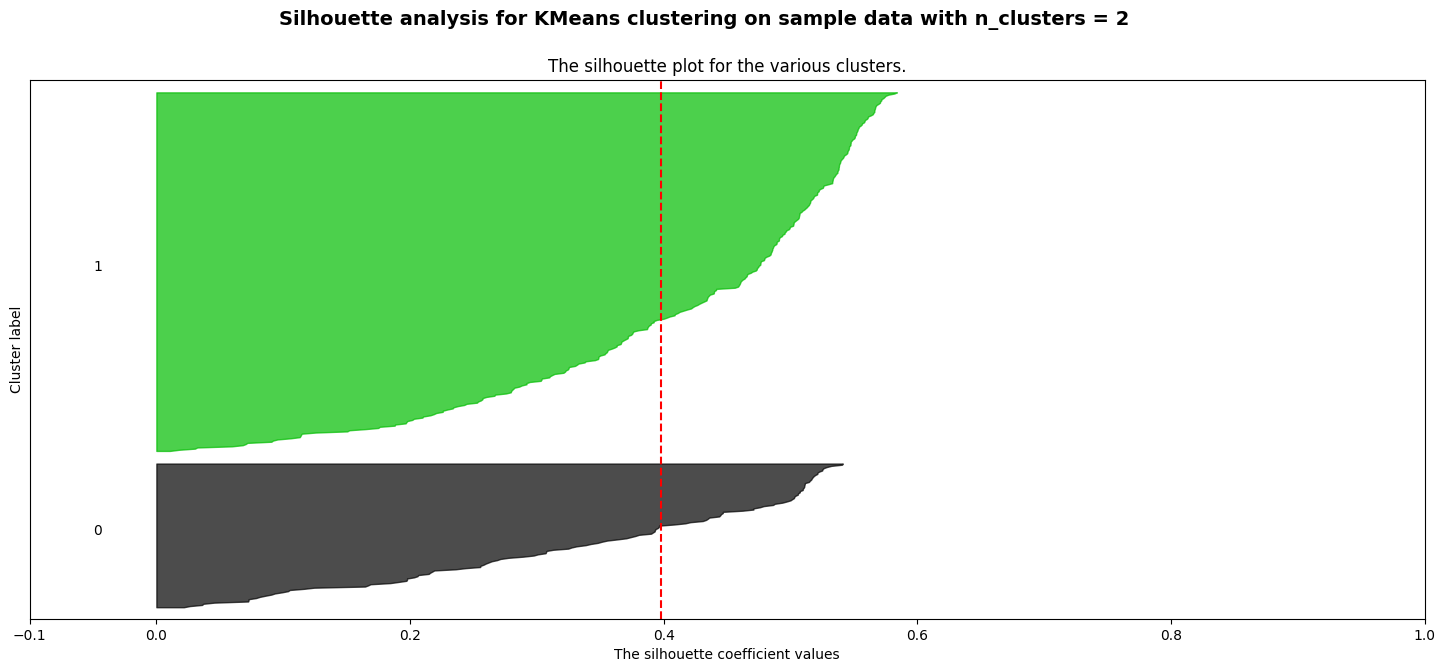

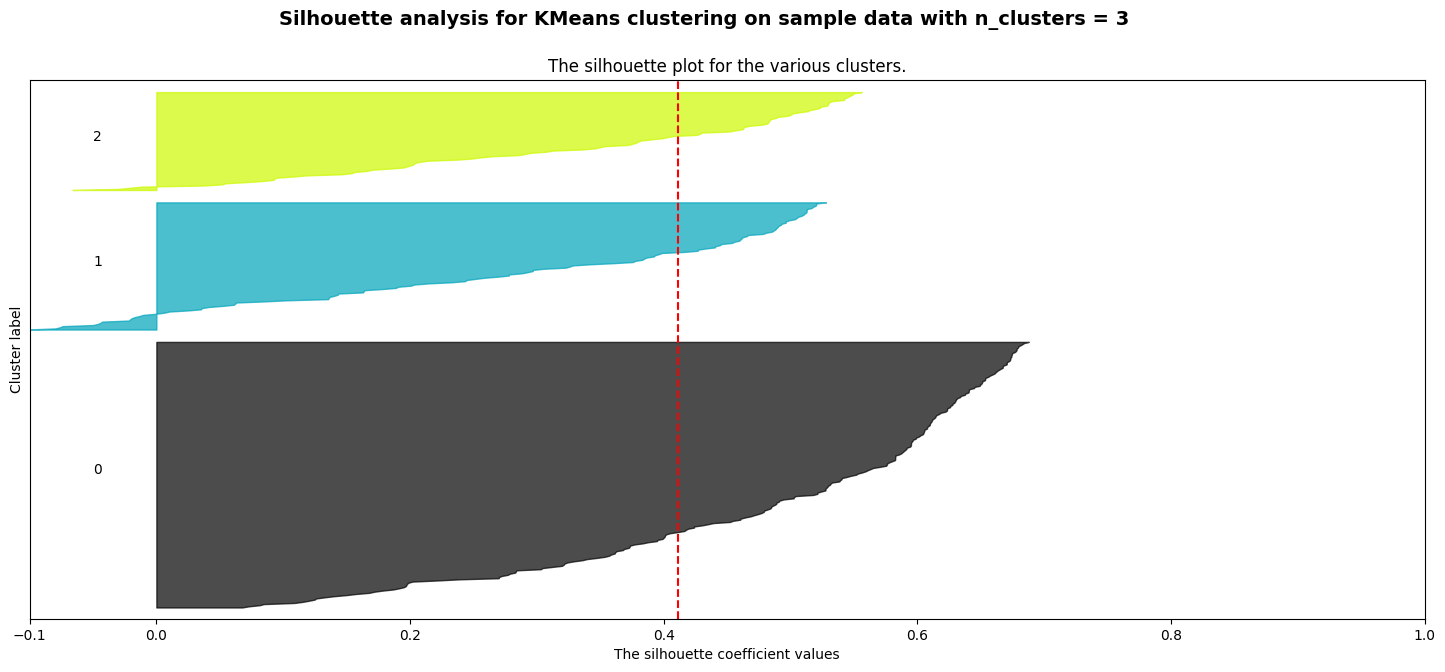

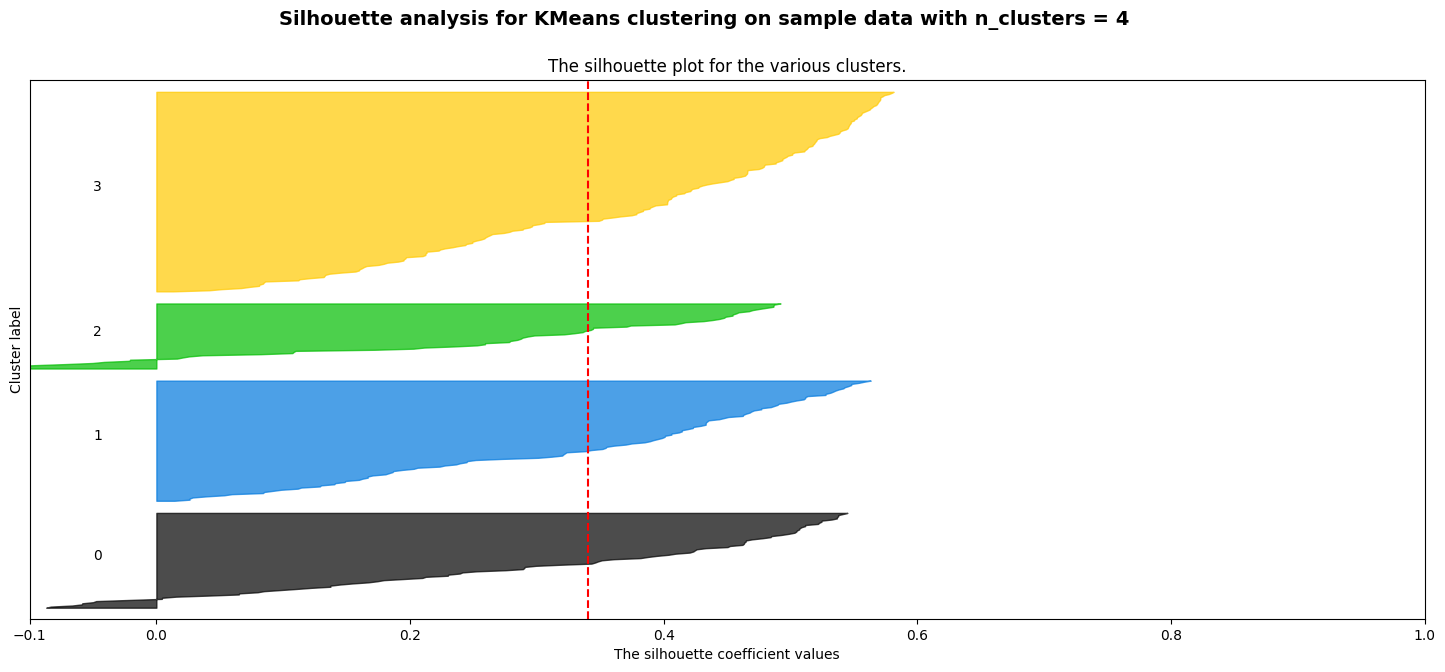

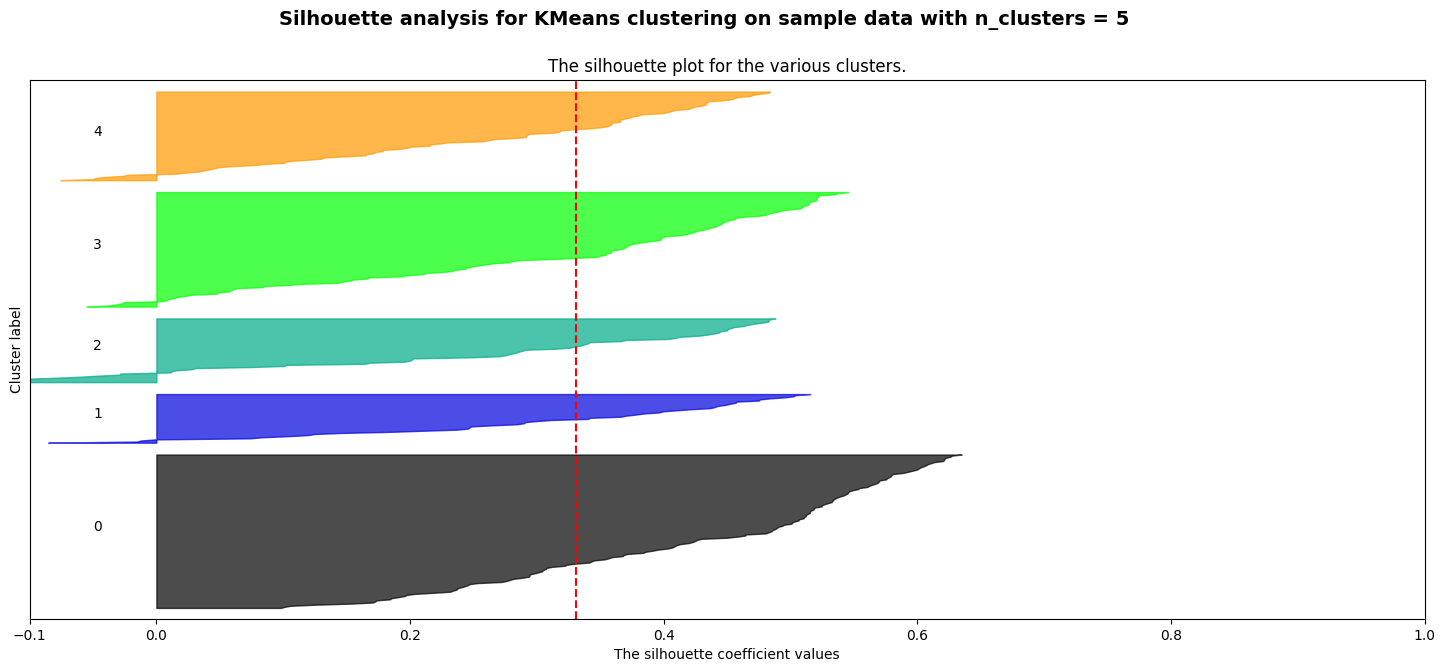

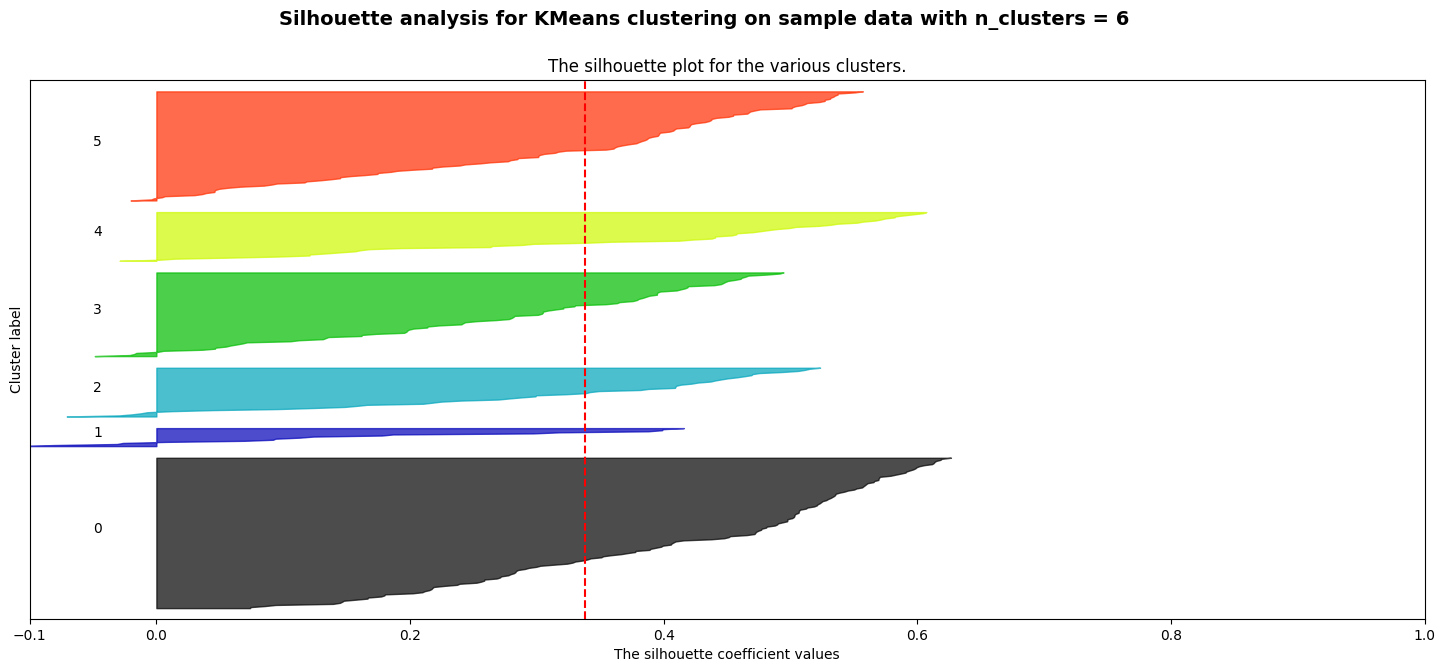

In [305]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
for n_clusters in range_n_clusters:

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
   
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

         # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10   # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As per the Silhouette Score, the optimal number of clusters is 3, as the Silhouette Score in k = 3 is the highest among other k values.

## Sales or marketing strategies for each customer segment

In [309]:
# run the clustering results with k = 2
df_3

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Cluster
0,online,Shenzhen,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,0
1,online,Shenzhen,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,0
2,online,Shenzhen,6353.0,8808.0,7684.0,2405.0,3516.0,4646.3,0
3,offline,Shenzhen,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,0
4,online,Shenzhen,22615.0,5410.0,7198.0,3915.0,1777.0,4646.3,1
...,...,...,...,...,...,...,...,...,...
435,offline,Shenzhen,29703.0,12051.0,16027.0,10017.3,182.0,2204.0,1
436,offline,Shenzhen,36865.9,1431.0,764.0,4510.0,93.0,2346.0,1
437,online,Shenzhen,14531.0,15488.0,24714.5,437.0,12237.0,1867.0,2
438,offline,Shenzhen,10290.0,1981.0,2232.0,1038.0,168.0,2125.0,0


In [311]:
# generate histograms for each sales in each product in each cluster
for i in df_3.select_dtypes(include='number').columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_3, x=i, hue='cluster', kde=True)
    plt.show()

ValueError: Could not interpret value `cluster` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

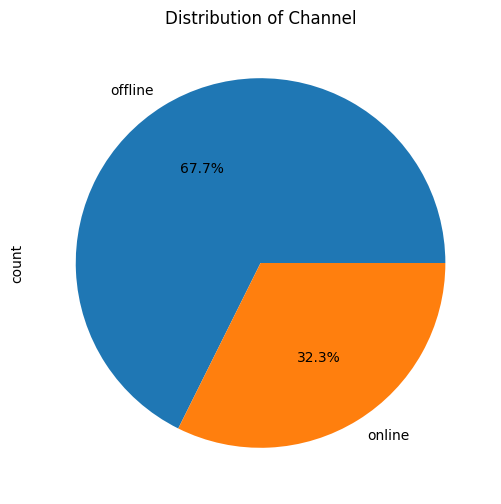

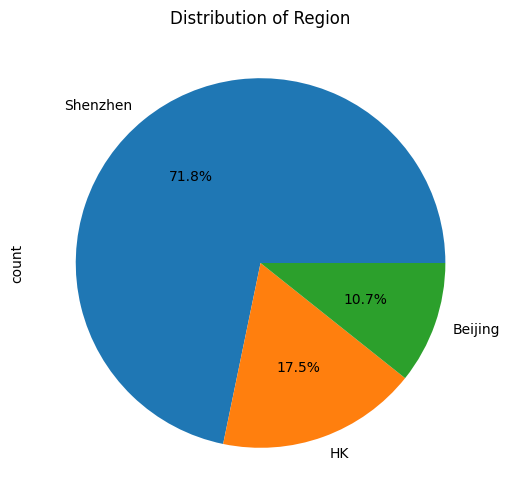

In [308]:
# generate pie charts for categorical data in each cluster
for i in df_3.select_dtypes(include='object').columns:
    plt.figure(figsize=(10, 6))
    df_3[i].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Distribution of {i}')
    plt.show()